## Данные

Мною был выбран следующий датасет:
https://www.kaggle.com/datasets/borhanitrash/animal-image-classification-dataset

В датасете 3000 изображений 256х256, по 1000 изображений на
- кошек
- собак
- змей

Классификация животных на изображении может помочь алгоритмам социальных сетей лучше выстраивать индивидуальную ленту пользователя на основе того, кого из домашних животных больше любит пользователь. Данные о любимом домашнем животном можно извлекать с помощью извлечения животных с постов с лайками и просмотрами пользователя.

In [1]:
!pip install kaggle
!pip install opendatasets
!pip install pandas

In [2]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/borhanitrash/animal-image-classification-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: xbhgbz
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/borhanitrash/animal-image-classification-dataset


In [83]:
import time
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import random_split, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def get_data_directory():
    return '/content/animal-image-classification-dataset/Animals/'

dataset = datasets.ImageFolder(get_data_directory(), transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
]))


train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

dataloaders = {'val': val_loader, 'train': train_loader}
dataset_sizes = {'val': len(val_dataset), 'train': len(train_dataset)}


class_names = dataset.classes
num_classes = len(class_names)

In [68]:
import time
import copy
import torch

def set_model_mode(model, phase):
    if phase == 'train':
        model.train()
    else:
        model.eval()

def get_data_loader(phase):
    return dataloaders[phase]

def move_to_device(inputs, labels):
    return inputs.to(device), labels.to(device)

def calculate_batch_loss(loss, inputs):
    return loss.item() * inputs.size(0)

def calculate_correct_predictions(preds, labels):
    return torch.sum(preds == labels.data)

def store_predictions(all_preds, all_labels, preds, labels):
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

def calculate_epoch_metrics(total_loss, corrects, phase):
    loss = total_loss / dataset_sizes[phase]
    accuracy = corrects.double() / dataset_sizes[phase]
    return loss, accuracy

def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    start_time = time.time()

    best_model_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0

    all_predictions = []
    all_true_labels = []

    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in get_data_loader(phase):
                inputs, labels = move_to_device(inputs, labels)
                optimizer.zero_grad()

                def forward_pass(model, inputs, labels, criterion, phase):
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                    return outputs, preds, loss

                def backward_pass(loss, optimizer):
                    loss.backward()
                    optimizer.step()

                outputs, predictions, loss = forward_pass(model, inputs, labels, criterion, phase)

                if phase == 'train':
                    backward_pass(loss, optimizer)

                running_loss += calculate_batch_loss(loss, inputs)
                running_corrects += calculate_correct_predictions(predictions, labels)

                if phase == 'val':
                    store_predictions(all_predictions, all_true_labels, predictions, labels)

            if phase == 'train':
                scheduler.step()

            epoch_loss, epoch_accuracy = calculate_epoch_metrics(running_loss, running_corrects, phase)
            print_metrics(epoch, phase, epoch_loss, epoch_accuracy)
            if phase == 'val' and float(epoch_accuracy) > best_accuracy:
                best_accuracy = float(epoch_accuracy)
                best_model_weights = copy.deepcopy(model.state_dict())

        print("==================================================================================================")

    model.load_state_dict(best_model_weights)
    return model, all_predictions, all_true_labels

def print_metrics(epoch, phase, loss, accuracy):
    print(epoch + 1, phase, " loss: ", loss, "acc:", float(accuracy))

In [69]:
def print_conf_matrix(labels, preds):
  cm = confusion_matrix(labels, preds)
  plt.figure(figsize=(8,6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr', xticklabels=class_names, yticklabels=class_names)

  plt.xlabel('Определенные значения')
  plt.ylabel('Настоящие значения')
  plt.show()

# Бейзлайн

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the wo

1 train  loss:  0.9027437472343445 acc: 0.655
1 val  loss:  0.6421045009295145 acc: 0.8550000000000001
2 train  loss:  0.5291798210144043 acc: 0.9104166666666668
2 val  loss:  0.4077697495619456 acc: 0.9516666666666668
3 train  loss:  0.36563469052314757 acc: 0.96125
3 val  loss:  0.294738316933314 acc: 0.9650000000000001
4 train  loss:  0.28064337611198426 acc: 0.9637500000000001
4 val  loss:  0.22693545937538148 acc: 0.9783333333333334
5 train  loss:  0.23454052885373433 acc: 0.9670833333333334
5 val  loss:  0.19140372276306153 acc: 0.9783333333333334


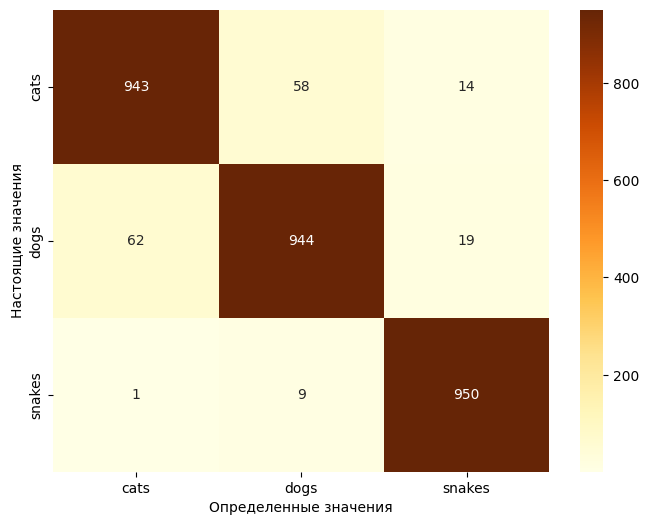

0.9456666666666667  - model total accuracy
0.9454816895718131  - model total f1


In [55]:
model_conv = models.resnet18(pretrained=True)
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, num_classes)
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.0002, momentum=0.6)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=5, gamma=0.3)
model_conv, preds, true_labels = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=5)
accuracy = accuracy_score(true_labels, preds)
f1 = f1_score(true_labels, preds, average='weighted')


print_conf_matrix(true_labels, preds)
print(accuracy, " - model total accuracy")
print(f1, " - model total f1")

1 train  loss:  0.46916255633036297 acc: 0.8795833333333334
1 val  loss:  0.19259569108486174 acc: 0.9783333333333334
2 train  loss:  0.10341255153218905 acc: 0.9900000000000001
2 val  loss:  0.09794233446319899 acc: 0.9816666666666667
3 train  loss:  0.050588170910875 acc: 0.99375
3 val  loss:  0.07439492781956991 acc: 0.9850000000000001
4 train  loss:  0.033671685059865314 acc: 0.9979166666666668
4 val  loss:  0.07022432823975881 acc: 0.9850000000000001
5 train  loss:  0.02955993906905254 acc: 0.9983333333333334
5 val  loss:  0.06738062769174576 acc: 0.9850000000000001


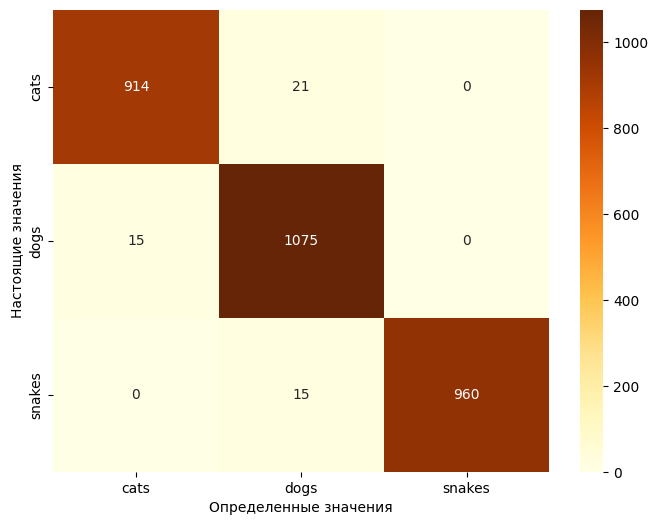

0.983  - model total accuracy
0.9830424063505449  - model total f1


In [84]:
model_vit = models.vit_b_16(pretrained=True)
model_vit.heads.head = nn.Linear(model_vit.heads.head.in_features, num_classes)
model_vit = model_vit.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_vit = optim.SGD(model_vit.parameters(), lr=0.001, momentum=0.6)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_vit, step_size=3, gamma=0.3)
model_vit, preds, true_labels = train_model(model_vit, criterion, optimizer_vit, exp_lr_scheduler, num_epochs=5)
accuracy = accuracy_score(true_labels, preds)
f1 = f1_score(true_labels, preds, average='weighted')


print_conf_matrix(true_labels, preds)
print(accuracy, " - model total accuracy")
print(f1, " - model total f1")

# Улучшение бейзлайна

In [105]:
from torch.utils.data import DataLoader

train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.1),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


full_dataset = datasets.ImageFolder(get_data_directory(), transform=train_transform)
total_size = len(full_dataset)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = test_transform


dataloaders = { 'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4), 'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)}
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}

class_names = full_dataset.classes
num_classes = len(class_names)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


1 train  loss:  0.12581662132715185 acc: 0.9525
1 val  loss:  0.14983511698742707 acc: 0.9500000000000001
2 train  loss:  0.017319856913139423 acc: 0.9966666666666667
2 val  loss:  0.06333969270189603 acc: 0.9783333333333334
3 train  loss:  0.013605027863911042 acc: 0.9941666666666668
3 val  loss:  0.08332761321837703 acc: 0.9716666666666667
4 train  loss:  0.006350711882890513 acc: 0.99875
4 val  loss:  0.08473586346954107 acc: 0.9783333333333334
5 train  loss:  0.005924181207665242 acc: 0.99875
5 val  loss:  0.04879023442044854 acc: 0.9816666666666667
6 train  loss:  0.0032190385765473667 acc: 1.0
6 val  loss:  0.04984114231231312 acc: 0.9850000000000001
7 train  loss:  0.0013595703128764095 acc: 1.0
7 val  loss:  0.05974198159451286 acc: 0.9850000000000001
8 train  loss:  0.0017599452420836315 acc: 0.9995833333333334
8 val  loss:  0.05644281771499664 acc: 0.9833333333333334
9 train  loss:  0.0015958912427110287 acc: 0.9995833333333334
9 val  loss:  0.058057371573522684 acc: 0.983333

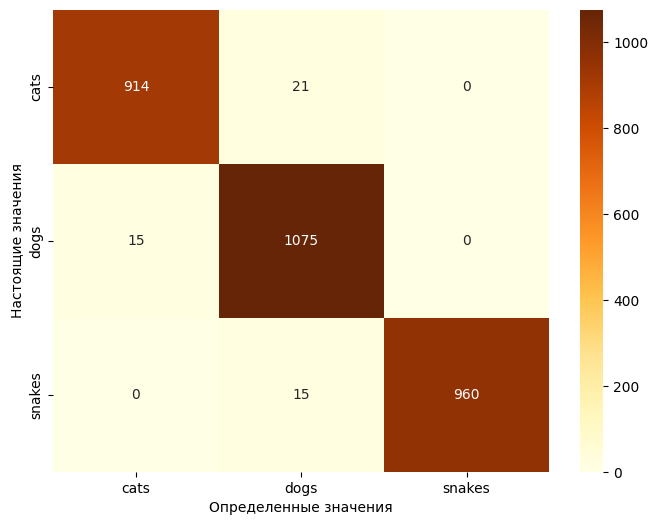

0.9781666666666666  - model total accuracy
0.9781374448750886  - model total f1


In [88]:
model_improved = models.resnet18(pretrained=True)
num_ftrs = model_improved.fc.in_features
model_improved.fc = nn.Linear(num_ftrs, num_classes)
model_improved = model_improved.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_improved = optim.Adam(model_improved.parameters(), lr=0.0001)
exp_lr_scheduler_improved = lr_scheduler.StepLR(optimizer_improved, step_size=7, gamma=0.1)
model_improved, preds_improved, labels_improved = train_model(model_improved,criterion,optimizer_improved,exp_lr_scheduler_improved,num_epochs=10)
accuracy = accuracy_score(labels_improved, preds_improved)
f1 = f1_score(labels_improved, preds_improved, average='weighted')

print_conf_matrix(labels_improved, preds_improved)
print(accuracy, " - model total accuracy")
print(f1, " - model total f1")


1 train  loss:  1.1175413926442463 acc: 0.3775
1 val  loss:  1.1038564157485962 acc: 0.3866666666666667
2 train  loss:  1.117541405359904 acc: 0.3775
2 val  loss:  1.1038564157485962 acc: 0.3866666666666667
3 train  loss:  1.1175413910547893 acc: 0.3775
3 val  loss:  1.1038564157485962 acc: 0.3866666666666667


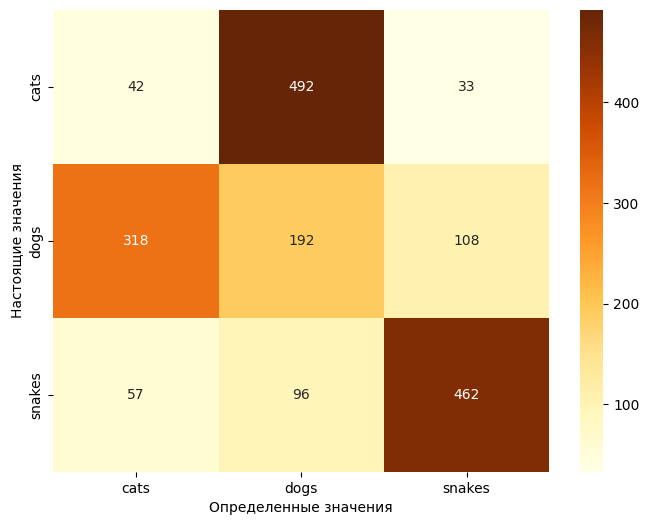

0.38666666666666666  - model total accuracy
0.380391797846497  - model total f1


In [107]:
model_vit_improved = models.vit_b_16(pretrained=True)
model_vit_improved.heads.head = nn.Linear(model_vit_improved.heads.head.in_features, num_classes)
model_vit_improved = model_vit_improved.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_improved = optim.Adam(model_improved.parameters(), lr=0.8)
exp_lr_scheduler_improved = lr_scheduler.StepLR(optimizer_improved, step_size=3, gamma=0.6)
model_vit_improved, preds_improved, labels_improved = train_model(model_vit_improved, criterion,optimizer_improved,exp_lr_scheduler_improved,num_epochs=3)
accuracy = accuracy_score(labels_improved, preds_improved)
f1 = f1_score(labels_improved, preds_improved, average='weighted')

print_conf_matrix(labels_improved, preds_improved)
print(accuracy, " - model total accuracy")
print(f1, " - model total f1")

In [98]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

Как видно из результатов обучения, добавление дополнительных аугментаций и модификаций к существующим данным положительно скзались на точности модели resnet и проявляется в увеличении accuracy и f1. К сожалению, трансформенная модель показала значительно более плохой результат, даже при подборе гиперпараметров.

# Имплементация алгоритмов машинного обучения

Реализую свои классы сверточной сети и трансформера

In [108]:
dataset = datasets.ImageFolder(get_data_directory(), transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
]))


train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

dataloaders = {'val': val_loader, 'train': train_loader}
dataset_sizes = {'val': len(val_dataset), 'train': len(train_dataset)}


class_names = dataset.classes
num_classes = len(class_names)

In [109]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(CustomCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model_custom = CustomCNN(num_classes=num_classes).to(device)
print(model_custom)

CustomCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

1 train  loss:  1.0304269011815388 acc: 0.47958333333333336
1 val  loss:  1.672427215576172 acc: 0.3166666666666667
2 train  loss:  0.8924716965357462 acc: 0.5750000000000001
2 val  loss:  2.002631672223409 acc: 0.31833333333333336
3 train  loss:  0.861999081770579 acc: 0.5850000000000001
3 val  loss:  1.7300942357381184 acc: 0.33666666666666667
4 train  loss:  0.8064348761240642 acc: 0.635
4 val  loss:  1.7556782833735147 acc: 0.34
5 train  loss:  0.793957556883494 acc: 0.6433333333333334
5 val  loss:  1.8024026950200398 acc: 0.33166666666666667


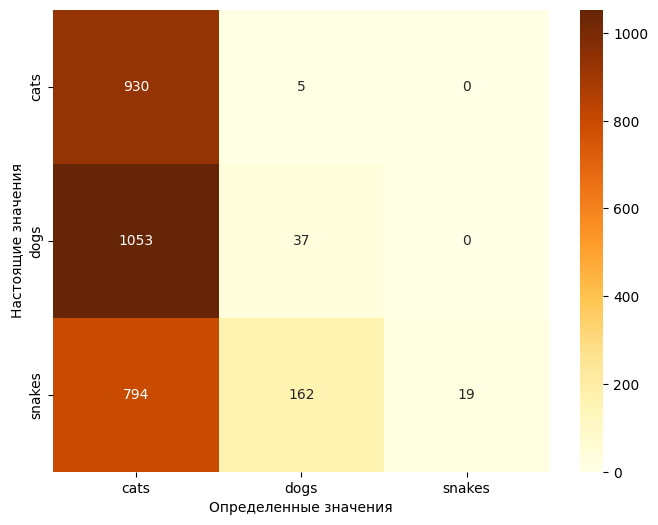

0.32866666666666666  - model total accuracy
0.18937167782874656  - model total f1


In [110]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_custom.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model_custom, preds, true_labels = train_model(model_custom, criterion, optimizer, scheduler, num_epochs=5)

accuracy = accuracy_score(true_labels, preds)
f1 = f1_score(true_labels, preds, average='weighted')

print_conf_matrix(true_labels, preds)
print(accuracy, " - model total accuracy")
print(f1, " - model total f1")

In [111]:
class VisionTransformer(nn.Module):
    def __init__(self, image_size=224, patch_size=16, in_channels=3, num_classes=6,
                 embed_dim=256, num_heads=8, depth=6, dropout=0.1):
        super().__init__()

        assert image_size % patch_size == 0, "Image dimensions must be divisible by the patch size."

        self.image_size = image_size
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        self.patch_dim = in_channels * patch_size * patch_size

        self.patch_embed = nn.Sequential(
            nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size),
            nn.Flatten(2)
        )

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=dropout)

        self.blocks = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dropout=dropout,
                activation='gelu',
                batch_first=True,
                norm_first=True
            ) for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        self._initialize_weights()

    def _initialize_weights(self):
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        self.apply(self._init_vit_weights)

    def _init_vit_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.weight, 1.0)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        B = x.shape[0]

        x = self.patch_embed(x).transpose(1, 2)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        x = x[:, 0]
        x = self.head(x)

        return x


model_vit = VisionTransformer(image_size=224,patch_size=16,num_classes=num_classes,embed_dim=256,num_heads=8,depth=6,dropout=0.1).to(device)
print(model_vit)

VisionTransformer(
  (patch_embed): Sequential(
    (0): Conv2d(3, 256, kernel_size=(16, 16), stride=(16, 16))
    (1): Flatten(start_dim=2, end_dim=-1)
  )
  (pos_drop): Dropout(p=0.1, inplace=False)
  (blocks): ModuleList(
    (0-5): 6 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (linear1): Linear(in_features=256, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=256, bias=True)
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=256, out_features=3, bias=True)
)


1 train  loss:  1.106865151723226 acc: 0.35083333333333333
1 val  loss:  1.069947237968445 acc: 0.42833333333333334
2 train  loss:  1.090552893479665 acc: 0.3804166666666667
2 val  loss:  1.0382484833399455 acc: 0.4816666666666667
3 train  loss:  1.0596419302622477 acc: 0.4370833333333334
3 val  loss:  0.9941648578643799 acc: 0.4916666666666667
4 train  loss:  1.0317436464627583 acc: 0.45833333333333337
4 val  loss:  1.0001166915893556 acc: 0.46
5 train  loss:  1.0110425233840943 acc: 0.4683333333333334
5 val  loss:  0.9962798094749451 acc: 0.48500000000000004


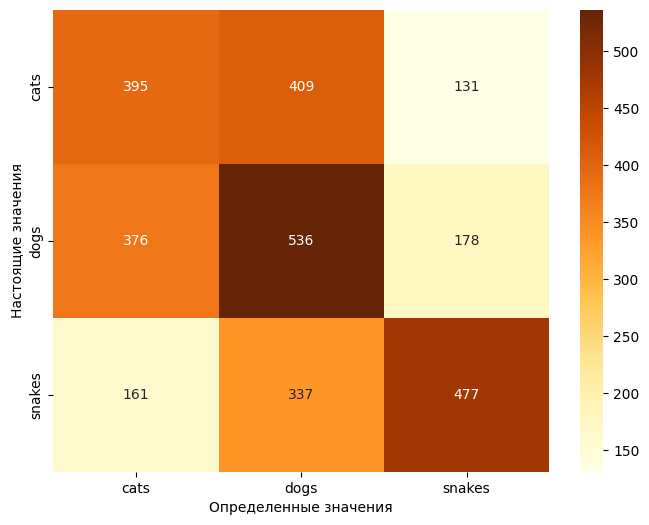

0.4693333333333333  - model total accuracy
0.4721475813058508  - model total f1


In [112]:
criterion = nn.CrossEntropyLoss()

optimizer_vit = optim.SGD(model_vit.parameters(), lr=0.001, momentum=0.6)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_vit, step_size=3, gamma=0.3)
model_vit, preds, true_labels = train_model(model_vit, criterion, optimizer_vit, exp_lr_scheduler, num_epochs=5)
accuracy = accuracy_score(true_labels, preds)
f1 = f1_score(true_labels, preds, average='weighted')


print_conf_matrix(true_labels, preds)
print(accuracy, " - model total accuracy")
print(f1, " - model total f1")

Реализованные мной модели показали значительно более плохой результат, чем модели resnet и vit

# Улучшенный бейзлайн

In [113]:
from torch.utils.data import DataLoader

train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.1),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


full_dataset = datasets.ImageFolder(get_data_directory(), transform=train_transform)
total_size = len(full_dataset)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = test_transform


dataloaders = { 'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4), 'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)}
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}

class_names = full_dataset.classes
num_classes = len(class_names)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


1 train  loss:  0.8207052254676819 acc: 0.6283333333333334
1 val  loss:  1.7105799690882364 acc: 0.37000000000000005
2 train  loss:  0.8489380280176798 acc: 0.6083333333333334
2 val  loss:  1.567944369316101 acc: 0.3916666666666667
3 train  loss:  0.8155097917715708 acc: 0.6433333333333334
3 val  loss:  2.174895652135213 acc: 0.38
4 train  loss:  0.7880200453599294 acc: 0.6420833333333333
4 val  loss:  1.6208759514490763 acc: 0.42000000000000004
5 train  loss:  0.7458278926213583 acc: 0.6604166666666668
5 val  loss:  1.3928156328201293 acc: 0.455


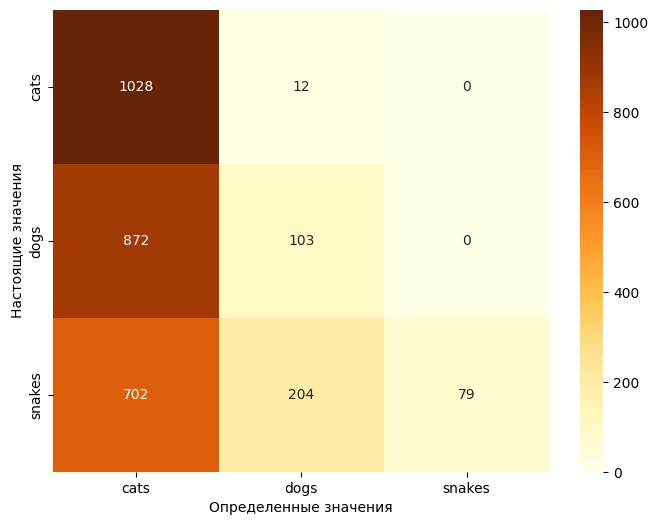

0.4033333333333333  - model total accuracy
0.2961970553407285  - model total f1


In [114]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_custom.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model_custom, preds, true_labels = train_model(model_custom, criterion, optimizer, scheduler, num_epochs=5)

accuracy = accuracy_score(true_labels, preds)
f1 = f1_score(true_labels, preds, average='weighted')

print_conf_matrix(true_labels, preds)
print(accuracy, " - model total accuracy")
print(f1, " - model total f1")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


1 train  loss:  1.0061551785469056 acc: 0.4791666666666667
1 val  loss:  1.0118498675028482 acc: 0.49500000000000005
2 train  loss:  0.9169230349858601 acc: 0.545
2 val  loss:  0.901265778541565 acc: 0.5533333333333333
3 train  loss:  0.8718195152282715 acc: 0.5687500000000001
3 val  loss:  0.8534062552452087 acc: 0.5800000000000001
4 train  loss:  0.840871029694875 acc: 0.5895833333333333
4 val  loss:  0.8258065485954285 acc: 0.5866666666666667
5 train  loss:  0.8317024874687194 acc: 0.5945833333333334
5 val  loss:  0.8385697833697001 acc: 0.5766666666666667


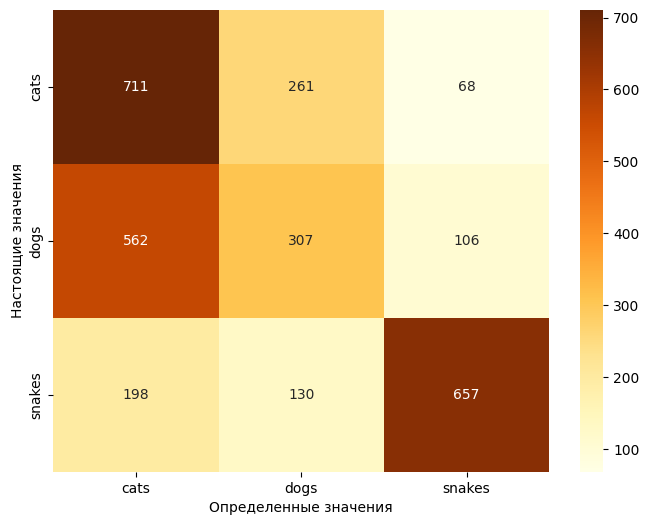

0.5583333333333333  - model total accuracy
0.5531685254182308  - model total f1


In [115]:
criterion = nn.CrossEntropyLoss()

optimizer_vit = optim.SGD(model_vit.parameters(), lr=0.001, momentum=0.6)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_vit, step_size=3, gamma=0.3)
model_vit, preds, true_labels = train_model(model_vit, criterion, optimizer_vit, exp_lr_scheduler, num_epochs=5)
accuracy = accuracy_score(true_labels, preds)
f1 = f1_score(true_labels, preds, average='weighted')


print_conf_matrix(true_labels, preds)
print(accuracy, " - model total accuracy")
print(f1, " - model total f1")

Мои реализации CNN и трансформера улучшили все свои показатели при использовании улучшенного бейзлайна